In [11]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance


%load_ext autoreload
%autoreload 2
from data_preprocessing import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Checking Data Quality For Main Station (Conde) and nearby stations

In [14]:
station_code = 'A431'
station_name = 'Conde'
station_file_name = glob.glob(f'./../../data/raw_data/*{station_code}*')[0]

df_raw = pd.read_csv(station_file_name,header=9,sep=';')
df = initial_data_preprocessing(df_raw,minimum_date='2015-01-01')

Dataset initial size:  (90072, 23)
Dataset final size:  (50956, 23)


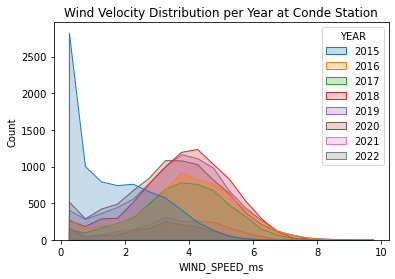

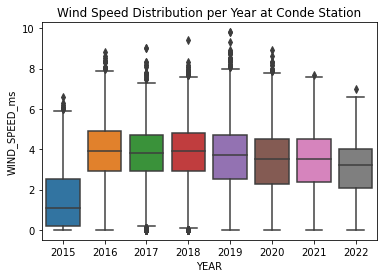

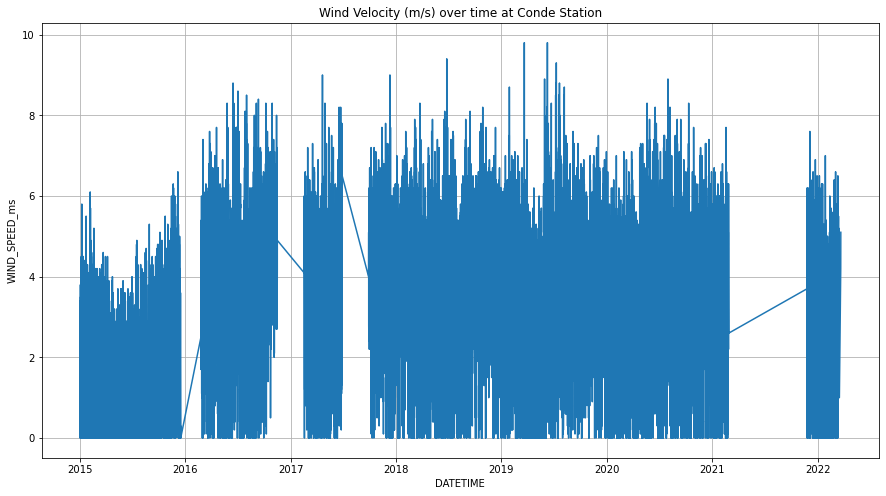

In [16]:

sns.histplot(data=df,x='WIND_SPEED_ms',binwidth=0.5,hue='YEAR', element="poly")
# sns.histplot(data=df.query("YEAR not in ('2017','2022')"),x='WIND_SPEED_ms',binwidth=0.5,hue='YEAR', element="poly")
plt.title(f"Wind Velocity Distribution per Year at {station_name} Station")
plt.show()

sns.boxplot(data=df,x='YEAR',y='WIND_SPEED_ms')
plt.title(f"Wind Speed Distribution per Year at {station_name} Station")
plt.show()

fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=df,y='WIND_SPEED_ms',x=df['DATETIME'])
plt.title(f"Wind Velocity (m/s) over time at {station_name} Station")
plt.grid(True)
plt.show()

As we can see, there are large chunks of missing data. Let us zoom in late 2017 and early 2021.

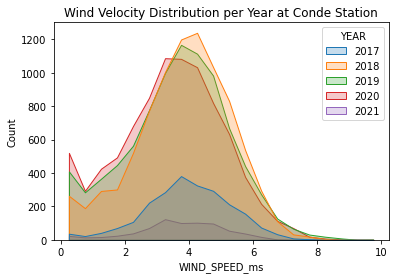

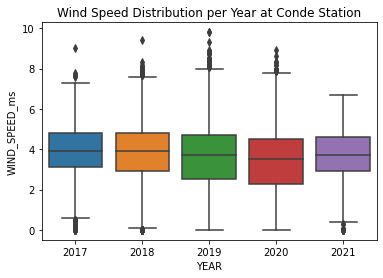

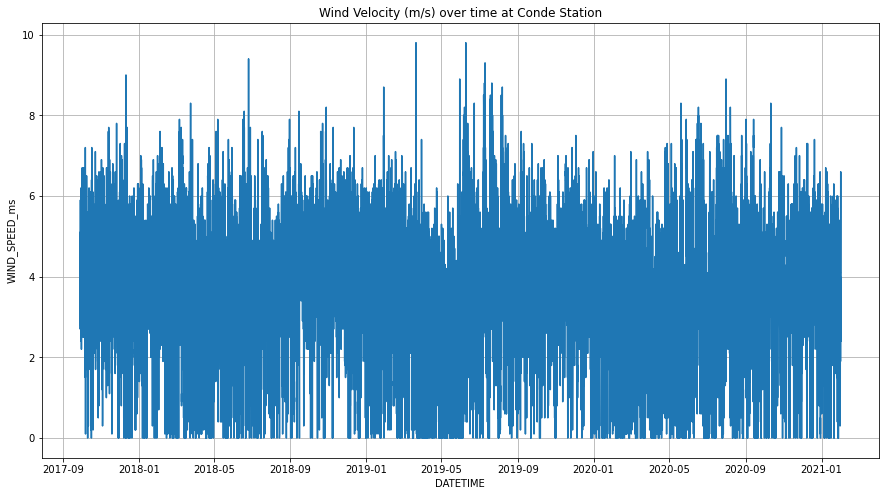

In [20]:
df_zoom = df.loc[(df['DATE_MEASUREMENT'] > '2017-09-01') & (df['DATE_MEASUREMENT'] < '2021-02-01'),:]

sns.histplot(data=df_zoom,x='WIND_SPEED_ms',binwidth=0.5,hue='YEAR', element="poly")
plt.title(f"Wind Velocity Distribution per Year at {station_name} Station")
plt.show()

sns.boxplot(data=df_zoom,x='YEAR',y='WIND_SPEED_ms')
plt.title(f"Wind Speed Distribution per Year at {station_name} Station")
plt.show()

fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=df_zoom,y='WIND_SPEED_ms',x=df_zoom['DATETIME'])
plt.title(f"Wind Velocity (m/s) over time at {station_name} Station")
plt.grid(True)
plt.show()

In [25]:
min_available_date = df_zoom['DATE_MEASUREMENT'][df_zoom['DATE_MEASUREMENT'].notna()].min()
max_available_date = df_zoom['DATE_MEASUREMENT'][df_zoom['DATE_MEASUREMENT'].notna()].max()
print("Min available Date:",min_available_date)
print("Max available Date:",max_available_date)

Min available Date: 2017-09-27
Max available Date: 2021-01-31


Also, we can see there are lots of time periods with 0 velocity.

At least for now, the best period to execute this study ranges from September, 27th of 2017 to January, 31th of 2021

## Checking adjacent stations to Conde with good quality data

In [68]:
df_automatic_stations = pd.read_csv("./../../data/automatic_stations_wind_statistics.csv")

In [69]:
latitude = df_automatic_stations.query("NOME == 'CONDE'")['LATITUDE'].iloc[0]
longitude = df_automatic_stations.query("NOME == 'CONDE'")['LONGITUDE'].iloc[0]

distances_km = [distance((latitude,longitude),(station[0],station[1])).km for station in 
                        zip(df_automatic_stations['LATITUDE'].values,
                            df_automatic_stations['LONGITUDE'].values)]
df_automatic_stations['DIST_KM'] = distances_km

In [70]:
df_top10_conde = df_automatic_stations.query("NON_NULL_RATIO >= 0.75").sort_values('DIST_KM',ascending=True)[['CD_ESTACAO','NOME','SG_ESTADO','DIST_KM']].iloc[1:10]
df_top10_conde

,CD_ESTACAO,NOME,SG_ESTADO,DIST_KM
73,A458,RIBEIRA DO AMPARO,BA,136.245855
17,A409,ARACAJU,SE,138.118352
67,A401,SALVADOR,BA,139.594926
40,A413,FEIRA DE SANTANA,BA,140.848866
38,A406,CRUZ DAS ALMAS,BA,168.450922
44,A442,EUCLIDES DA CUNHA,BA,219.134789
59,A450,JEREMOABO,BA,228.026422
75,A434,AMARGOSA,BA,236.091854
20,A436,QUEIMADAS,BA,240.813463


We filtered the top 9 closest stations to Conde with at least 75% of available data, from 2018 to 2021

In [72]:
df_top10_conde['NOME'].tolist()

['RIBEIRA DO AMPARO',
 'ARACAJU',
 'SALVADOR',
 'FEIRA DE SANTANA',
 'CRUZ DAS ALMAS',
 'EUCLIDES DA CUNHA',
 'JEREMOABO',
 'AMARGOSA',
 'QUEIMADAS']

In [73]:
df_top10_conde['CD_ESTACAO'].tolist()

['A458', 'A409', 'A401', 'A413', 'A406', 'A442', 'A450', 'A434', 'A436']